In [1]:
import glob
import os
import librosa
import numpy as np
from sklearn import tree

In [2]:
def extract_features(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.array(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=8).T)
    chroma = np.array(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T)
    mel = np.array(librosa.feature.melspectrogram(X, sr=sample_rate).T)
    contrast = np.array(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T)
    tonnetz = np.array(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T)
    return mfccs,chroma,mel,contrast,tonnetz

In [3]:
def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    ignored = 0
    features, labels, name = np.empty((0,161)), np.empty(0), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        print(sub_dir)
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
                mfccs, chroma, mel, contrast, tonnetz = extract_features(fn)
                ext_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
                features = np.vstack([features,ext_features])
                l = [fn.split('-')[1]] * (mfccs.shape[0])
                labels = np.append(labels, l)
            except (KeyboardInterrupt, SystemExit):
                raise
            except:
                ignored += 1
    print ("Ignored files: ", ignored)
    return np.array(features), np.array(labels, dtype = np.int)

In [4]:
parent_dir = 'C:/Users/rano4/Desktop/5thyear/graduationproject/Project/UrbanSound8K/audio'

sub_dirs = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10']
#sub_dirs = ['fold1']

In [5]:
try:
    labels = np.load('labels.npy')
    features = np.load('features.npy')
    print("Features and labels found!")
except:
    print("Extracting features...")
    features, labels = parse_audio_files(parent_dir,sub_dirs)
    print(features)
    with open('features.npy', 'wb') as f1:
            np.save(f1,features)
    with open('labels.npy', 'wb') as f2:
            np.save(f2, labels)

Features and labels found!


In [6]:
from sklearn.model_selection import train_test_split
print("Splitting and fitting!")
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.3, random_state=0)

Splitting and fitting!


In [7]:

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(train_x)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
with open("fit_params.npy", "wb") as f3:
    np.save(f3, train_x)
train_x = sc.transform(train_x)
test_x = sc.transform(test_x)

In [9]:
X = train_x
Y = train_y

In [13]:
clf = tree.DecisionTreeClassifier(max_depth = 23,min_samples_leaf=7)
clf = clf.fit(X,Y)

In [14]:
clf.score(test_x, test_y) 

0.8124087287706484

In [15]:
clf.score(X,Y)   

0.89151836961478581

## Saving model

In [16]:
print("saving model")
import pickle
with open('res_model.pkl', 'wb') as fout:
    pickle.dump((sc, clf), fout)

saving model


## retore the model

In [17]:
print("load model")  
with open('res_model.pkl', 'rb') as fin:
    sc, clf = pickle.load(fin)

load model


## ploting Decision tree

In [ ]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data) 
graph.render("Sound tree") 
#graph

## confusion matrix

[[45824   156  1429   382   345   520    76   778   268  1591]
 [  259 10078  1013   254   240   196    35   301   272   948]
 [ 1316   618 36660  3012   917  1058   237   669  1550  5375]
 [  615   246  4340 30019   652   513   646   243  1276  2326]
 [  409   224  1618   771 39632   228   152  1687   224  1188]
 [  650   156  1369   453   206 46238    61   528   365   981]
 [  119    42   688  1038   315   102  5118   206    94   347]
 [  797   203   779   232  1374   476    71 41571   233  1283]
 [  438   215  2238  1113   239   418    69   323 40922  1288]
 [ 1725   829  6470  1919  1159  1043   193  1379  1290 36058]]


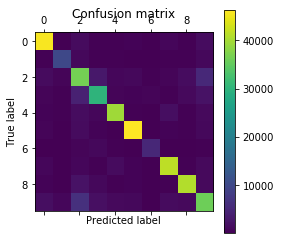

In [18]:
#confusion matrix 
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(test_x)
# Compute confusion matrix
cm = confusion_matrix(test_y, y_pred)

import matplotlib.pyplot as plt
print(cm)

# Show confusion matrix in a separate window
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Precision and Recall Score

In [19]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
# For each class
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
y_test_new = label_binarize(test_y, classes=[0, 1, 2,3,4,5,6,7,8,9])
y_score =  label_binarize(y_pred, classes=[0, 1, 2,3,4,5,6,7,8,9])
n_classes = y_test_new.shape[1]
precision = dict()
recall = dict()
average_precision = dict()
print(n_classes)
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_new[:, i],y_score[:, i])
    average_precision[i] = average_precision_score(y_test_new[:, i], y_score[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_new.ravel(),y_score.ravel())
average_precision["micro"] = average_precision_score(y_test_new, y_score,average="micro")


10


In [20]:
%matplotlib notebook
import warnings; warnings.simplefilter('ignore')
from sklearn.metrics import classification_report
print(classification_report(test_y, y_pred))

             precision    recall  f1-score   support

          0       0.88      0.89      0.89     51369
          1       0.79      0.74      0.76     13596
          2       0.65      0.71      0.68     51412
          3       0.77      0.73      0.75     40876
          4       0.88      0.86      0.87     46133
          5       0.91      0.91      0.91     51007
          6       0.77      0.63      0.70      8069
          7       0.87      0.88      0.88     47019
          8       0.88      0.87      0.87     47263
          9       0.70      0.69      0.70     52065

avg / total       0.81      0.81      0.81    408809



## Precision-recall curves

<IPython.core.display.Javascript object>


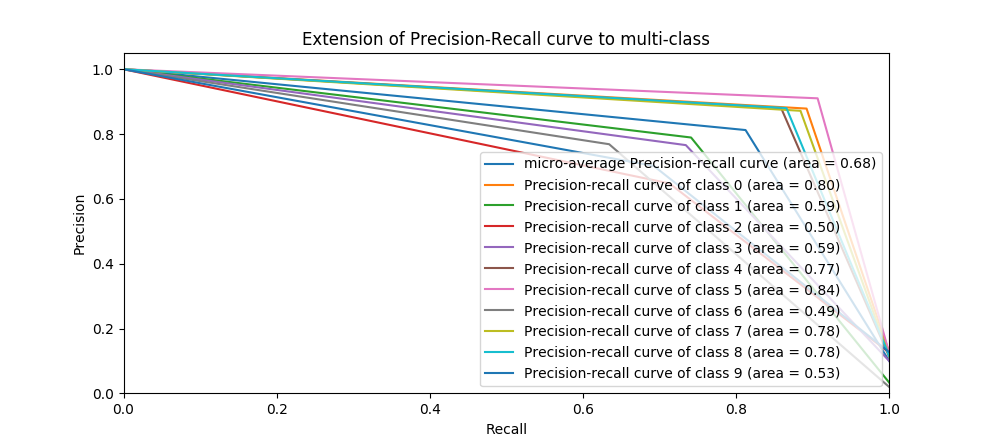

In [21]:
# Plot Precision-Recall curve
plt.clf()
plt.plot(recall[0], precision[0], label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()

# Plot Precision-Recall curve for each class
plt.clf()
plt.plot(recall["micro"], precision["micro"],
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i in range(n_classes):
    plt.plot(recall[i], precision[i],
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(i, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()

## plot Precision Recall for specific class

<IPython.core.display.Javascript object>


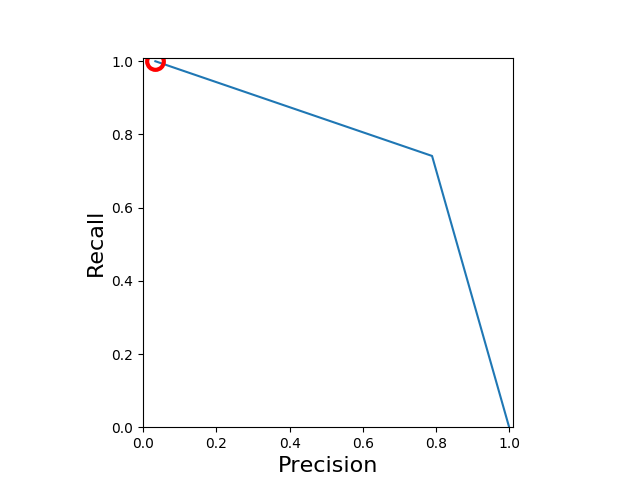

In [22]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test_new[:,1], y_score[:,1])
# index of the closest threshold value to zero 
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

## ROC curve for a specific class

In [23]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_new[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_new.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

[ 0.          0.19363622  0.34283736  0.64132597  0.7567756   0.77656196
  0.85152508  0.89205552  0.89285005  0.89483133  0.89624231  1.        ]
[ 0.          0.61229639  1.08408479  1.38411669  1.50016324  1.5200519
  1.5954026   1.6361426   1.63882078  1.64549926  1.65025535  2.        ]
[ 0.          0.66140126  1.1710261   1.54675276  1.69207658  1.71698293
  1.81134378  1.86236204  1.95742872  2.1944926   2.36331845  3.        ]
[ 0.          0.77458809  1.37142596  1.92162916  2.13443713  2.17090926
  2.30908856  2.38379821  2.69182054  2.93379571  3.10611915  4.        ]
[ 0.          0.99440128  1.76061026  2.64965366  2.99351849  3.0300468
  3.16843894  3.24326367  3.5523204   3.79687503  3.97103545  5.        ]
[ 0.          1.26810268  2.24520487  3.55615669  3.9002385   3.936804
  4.07533702  4.15023793  4.45997939  4.70624147  4.88161785  6.        ]
[ 0.          1.90238203  2.8805713   4.19369793  4.53862091  4.57533057
  4.71440979  4.789606    5.1020019   5.35488325 

<IPython.core.display.Javascript object>


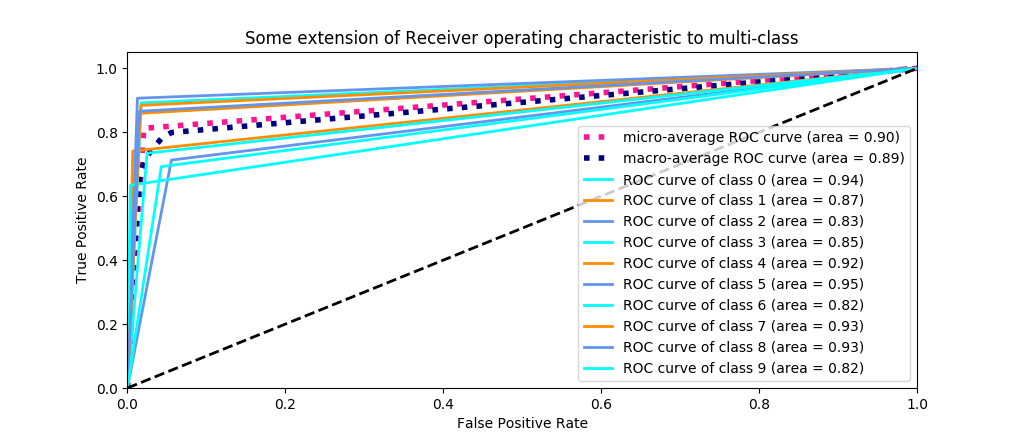

In [24]:
lw = 2
def cycle(iterable):
    # cycle('ABCD') --> A B C D A B C D A B C D ...
    saved = []
    for element in iterable:
        yield element
        saved.append(element)
    while saved:
        for element in saved:
              yield element

# Compute macro-average ROC curve and ROC area
from scipy import interp
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
#print(all_fpr)
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    print(mean_tpr)
    
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()